In [3]:
import pandas as pd
import numpy as np

n=3 # количество событий
deg=4 # max степеyь полинома

df = pd.read_excel('files/smspecs_yearly.xlsx', sheet_name=None,  index_col=0)

# получаем базовую обучающую выборку 2**n вариантов
base_train_df=pd.DataFrame()
for key in [k for k in df if k.endswith('-xxxx'*n)]:
    df[key]['type']=int(key[:n], 2)
    base_train_df=pd.concat([base_train_df, df[key]])
base_train_df['year']=base_train_df.index.year.to_list()
    
# получаем матрицу коэффициентов. апроксимируем полиномами степени deg бызовые варианты
base_coefs=np.zeros((2**n, deg+1))
for i in range(2**n):
    d=base_train_df.loc[base_train_df.type==i]
    base_coefs[i]=np.polyfit(d.total, d.yearly, deg)

In [4]:
# преобразуем условия, заданные пользователем, в df удобный для 
key='100-2019-xxxx-xxxx'
vars={'status': [1, 0, 0], 'year' : [2019, 0, 0]}

df_vars=pd.DataFrame(data=vars)
columns=[str(i) for i in df_vars.index]
df_status=pd.DataFrame(columns=columns)
df_status['year']=base_train_df.index.year.unique()

for i, col in enumerate(columns):
    df_status[col]=np.where((df_vars.status[i]==1) & (df_status.year>=df_vars.year[i]), str(1), str(0))

df_status['bin_str']=df_status[columns].agg(''.join, axis=1)
df_status['type']=df_status['bin_str'].apply(lambda x: int(x, 2)).astype(int)
df_status.drop(columns=columns, axis=1, inplace=True)

In [5]:
df_res=pd.DataFrame(columns=['year', 'x', 'y'])
df_res=df_status.merge(df_res, how='left')
df_res = df_res.merge(base_train_df, how='inner', left_on=['year', 'type'], right_on=['year', 'type'])

In [6]:
# proxy_v1, идеи как у Никиты, код мой
df_res.loc[0, 'x']=df_res.loc[0, 'total']
for i in range(len(df_res)):
    fb=np.poly1d(base_coefs[df_res.type[i]])
    df_res.loc[i, 'y']=fb(df_res.x[i])
    if (i+1)<len(df_res):
        df_res.loc[i+1, 'x']=df_res.x[i]+df_res.y[i]

In [ ]:
# # proxy_v2, с учетом приростов только от базового варианта
# base_type=0
# df_res.loc[0, 'x']=df_res.loc[0, 'total']
# for i in range(len(df_res)):
#     #proxy_v2
#     if df_res.type[i]==base_type:
#         base_f=np.poly1d(base_coefs[df_res.type[i]])
#         df_res.loc[i, 'y']=base_f(df_res.x[i])
#     else:
#         # вычисляем тренд по приростам
#         train_set_keys=[k for k in df if int(k[:3], 2)==df_res.type[i] and k[3:]!='-xxxx'*3]
#         x, y=[],[]
#         for key in train_set_keys:
#             g=df[key]
#             g['growth_by_year']=g.yearly-base_train_df.loc[base_train_df.type==base_type].yearly
#             g=g.loc[g.growth_by_year.cumsum()>0]
#             if len(g)>0:
#                 x.append(g.iloc[0].total)
#                 y.append(g.iloc[0].growth_by_year)
#         growth_coefs = np.polyfit(x, y, deg) if len(x)>=(deg+1) else np.polyfit(x, y, len(x)-1)
        
#         base_f=np.poly1d(base_coefs[base_type])
#         growth_f=np.poly1d(growth_coefs)
#         df_res.loc[i, 'y']=base_f(df_res.x[i])+growth_f(df_res.x[i])
#         base_type=df_res.type[i]
#     if (i+1)<len(df_res):
#         df_res.loc[i+1, 'x']=df_res.x[i]+df_res.y[i]

0.010389463936299878


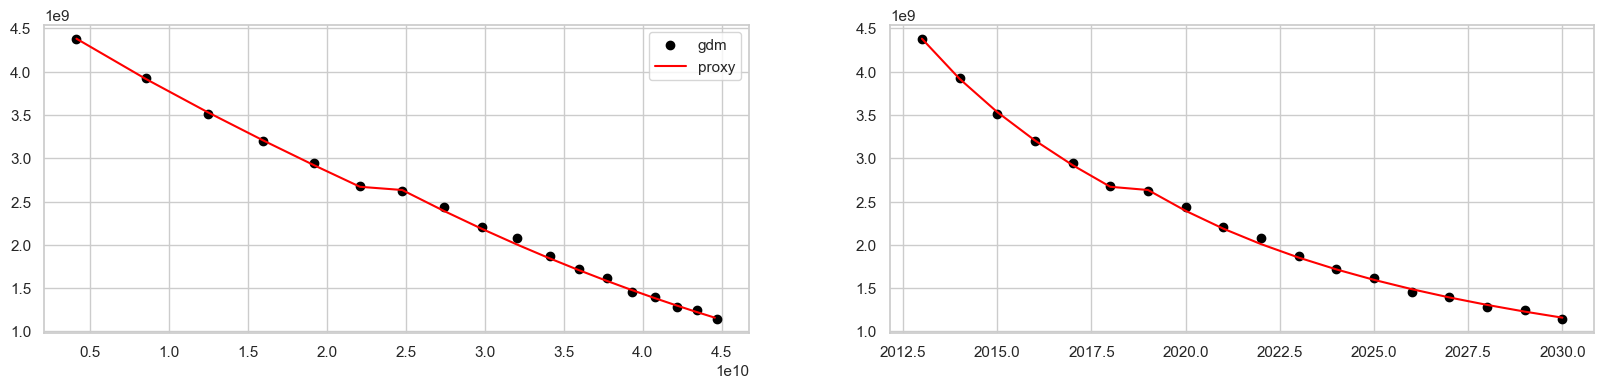

In [14]:
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize' : (20,10)}, style='whitegrid')

print(mean_absolute_percentage_error(df[key].yearly, df_res.y))
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
ax[0].scatter(df[key].total, df[key].yearly, color='black', label='gdm')
ax[0].plot(df_res.x, df_res.y, label='proxy', color='red')
ax[0].legend()
ax[1].scatter(df[key].index.year.to_list(), df[key].yearly, color='black', label='gdm')
ax[1].plot(df_res.year, df_res.y, label='proxy', color='red')
ax[0].legend()

In [ ]:
# # proxy_v2, с учетом приростов

# base_type=0
# df_res[['x1', 'y1']]=0
# df_res.loc[0, 'x']=df_res.loc[0, 'total']
# df_res.loc[0, 'x1']=df_res.loc[0, 'total']
# df_res
# for i in range(len(df_res)):
#     #proxy_v2
#     if df_res.type[i]==base_type:
#         base_f=np.poly1d(base_coefs[df_res.type[i]])
#         df_res.loc[i, 'y']=base_f(df_res.x[i])
#     else:
#         # вычисляем тренд по приростам
#         train_set_keys=[k for k in df if int(k[:3], 2)==df_res.type[i] and k[3:]!='-xxxx'*3]
#         x, y=[],[]
#         for key in train_set_keys:
#             g=df[key]
#             g['growth_by_year']=g.yearly-base_train_df.loc[base_train_df.type==base_type].yearly
#             g=g.loc[g.growth_by_year.cumsum()>0]
#             if len(g)>0:
#                 x.append(g.iloc[0].total)
#                 y.append(g.iloc[0].growth_by_year)
#         growth_coefs = np.polyfit(x, y, deg) if len(x)>=(deg+1) else np.polyfit(x, y, len(x)-1)
        
#         base_f=np.poly1d(base_coefs[base_type])
#         growth_f=np.poly1d(growth_coefs)
#         df_res.loc[i, 'y']=base_f(df_res.x[i])+growth_f(df_res.x[i])
#         base_type=df_res.type[i]
#     if (i+1)<len(df_res):
#         df_res.loc[i+1, 'x']=df_res.x[i]+df_res.y[i]
   
#     #proxy_v1
#     f=np.poly1d(base_coefs[df_res.type[i]])
#     df_res.loc[i, 'y1']=f(df_res.x1[i])
#     if (i+1)<len(df_res):
#         df_res.loc[i+1, 'x1']=df_res.x1[i]+df_res.y1[i]    
# df_res